# Numerical Dynamic Programming
 
Florian Oswald, Sciences Po, 2019




## Intro

* Numerical Dynamic Programming (DP) is widely used to solve dynamic models.
* You are familiar with the technique from your core macro course.
* We will illustrate some ways to solve dynamic programs.
    1. Models with one discrete or continuous choice variable
    1. Models with several choice variables
	1. Models with a discrete-continuous choice combination
* We will go through:
	1. Value Function Iteration (VFI)
    1. Policy function iteration (PFI)
    1. Projection Methods
	1. Endogenous Grid Method (EGM)
	1. Discrete Choice Endogenous Grid Method (DCEGM)


## Dynamic Programming Theory

* Payoffs over time are 
	$$U=\sum_{t=1}^{\infty}\beta^{t}u\left(s_{t},c_{t}\right) $$
	where $\beta<1$ is a discount factor, $s_{t}$ is the state, $c_{t}$ is the control.

* The state (vector) evolves as $s_{t+1}=h(s_{t},c_{t})$.
* All past decisions are contained in $s_{t}$.

### Assumptions

* Let $c_{t}\in C(s_{t}),s_{t}\in S$ and assume $u$ is bounded in $(c,s)\in C\times S$.
* Stationarity: neither payoff $u$ nor transition $h$ depend on time.
* Write the problem as 
	$$ v(s)=\max_{s'\in\Gamma(s)}u(s,s')+\beta v(s') $$
* $\Gamma(s)$ is the constraint set (or feasible set) for $s'$ when the current state is $s$

### Existence

**Theorem.** Assume that $u(s,s')$ is real-valued, continuous, and bounded, that $\beta\in(0,1)$, and that the constraint set $\Gamma(s)$ is nonempty, compact, and continuous. Then there exists a unique function $v(s)$ that solves the above functional equation.

**Proof.** [@stokeylucas] <cite data-cite=stokeylucas></cite> theoreom 4.6.

# Solution Methods

## Value Function Iteration (VFI)

* Find the fix point of the functional equation by iterating on it until the distance between consecutive iterations becomes small.
* Motivated by the Bellman Operator, and it's characterization in the Continuous Mapping Theorem.

## Discrete DP VFI

* Represents and solves the functional problem in $\mathbb{R}$ on a finite set of grid points only.
* Widely used method.
	* Simple (+)
	* Robust (+)
	* Slow (-)
	* Imprecise (-)
* Precision depends on number of discretization points used. 
* High-dimensional problems are difficult to tackle with this method because of the curse of dimensionality.



### Deterministic growth model with Discrete VFI

* We have this theoretical model:

$$
\begin{aligned}
   V(k) &= \max_{0<k'<f(k)} u(f(k) - k') + \beta V(k')\\
  f(k)  & = k^\alpha\\
  k_0   & \text{given} 
\end{aligned}
$$

* and we employ the followign numerical approximation:
	$$ V(k_i) = \max_{i'=1,2,\dots,n} u(f(k_i) - k_{i'}) + \beta V(i') $$

* The iteration is then on successive iterates of $V$: The LHS gets updated in each iteration!

$$
\begin{aligned}
	V^{r+1}(k_i) &= \max_{i'=1,2,\dots,n} u(f(k_i) - k_{i'}) + \beta V^{r}(i') \\
	V^{r+2}(k_i) &= \max_{i'=1,2,\dots,n} u(f(k_i) - k_{i'}) + \beta V^{r+1}(i') \\
	... & 
\end{aligned}
$$

* And it stops at iteration $r$ if $d(V^{r},V^{r-1}) < \text{tol}$
* You choose a measure of *distance*, $d(\cdot,\cdot)$, and a level of tolerance.
* $V^{r}$ is usually an *array*. So $d$ will be some kind of *norm*.
* maximal absolute distance
* mean squared distance

### Exercise 1: Implement discrete VFI

## Checklist

1. Set parameter values
1. define a grid for state variable $k \in [0,2]$
1. initialize value function $V$
1. start iteration, repeatedly computing a new version of $V$.
1. stop if $d(V^{r},V^{r-1}) < \text{tol}$.
1. plot value and policy function 
1. report the maximum error of both wrt to analytic solution

In [1]:
alpha     = 0.65
beta      = 0.95
grid_max  = 2  # upper bound of capital grid
n         = 150  # number of grid points
N_iter    = 3000  # number of iterations
kgrid     = 1e-2:(grid_max-1e-2)/(n-1):grid_max  # equispaced grid
f(x) = x^alpha  # defines the production function f(k)
tol = 1e-9


1.0e-9

## Analytic Solution

* If we choose $u(x)=\ln(x)$, the problem has a closed form solution.
* We can use this to check accuracy of our solution.

In [2]:
ab        = alpha * beta
c1        = (log(1 - ab) + log(ab) * ab / (1 - ab)) / (1 - beta)
c2        = alpha / (1 - ab)
# optimal analytical values
v_star(k) = c1 .+ c2 .* log.(k)  
k_star(k) = ab * k.^alpha   
c_star(k) = (1-ab) * k.^alpha  
ufun(x) = log.(x)

ufun (generic function with 1 method)

In [3]:
kgrid[4]

0.04026943624161074

┌ Info: Recompiling stale cache file /Users/florian.oswald/.julia/compiled/v1.1/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1184


Found solution after 418 iterations
maximal value function error = 0.09528625737115703
maximal policy function error = 0.011773635481976297


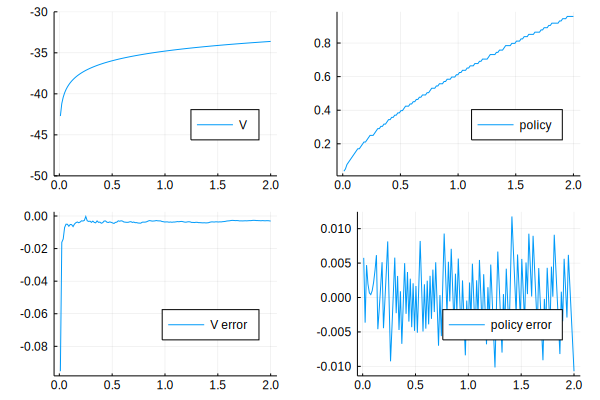

In [3]:
# Bellman Operator
# inputs
# `grid`: grid of values of state variable
# `v0`: current guess of value function

# output
# `v1`: next guess of value function
# `pol`: corresponding policy function 

#takes a grid of state variables and computes the next iterate of the value function.
function bellman_operator(grid,v0)
    
    v1  = zeros(n)     # next guess
    pol = zeros(Int,n)     # policy function
    w   = zeros(n)   # temporary vector 

    # loop over current states
    # current capital
    for (i,k) in enumerate(grid)

        # loop over all possible kprime choices
        for (iprime,kprime) in enumerate(grid)
            if f(k) - kprime < 0   #check for negative consumption
                w[iprime] = -Inf
            else
                w[iprime] = ufun(f(k) - kprime) + beta * v0[iprime]
            end
        end
        # find maximal choice
        v1[i], pol[i] = findmax(w)     # stores Value und policy (index of optimal choice)
    end
    return (v1,pol)   # return both value and policy function
end



# VFI iterator
#
## input
# `n`: number of grid points
# output
# `v_next`: tuple with value and policy functions after `n` iterations.
function VFI()
    v_init = zeros(n)     # initial guess
    for iter in 1:N_iter
        v_next = bellman_operator(kgrid,v_init)  # returns a tuple: (v1,pol)
        # check convergence
        if maximum(abs,v_init.-v_next[1]) < tol
            verrors = maximum(abs,v_next[1].-v_star(kgrid))
            perrors = maximum(abs,kgrid[v_next[2]].-k_star(kgrid))
            println("Found solution after $iter iterations")
            println("maximal value function error = $verrors")
            println("maximal policy function error = $perrors")
            return v_next
        elseif iter==N_iter
            warn("No solution found after $iter iterations")
            return v_next
        end
        v_init = v_next[1]  # update guess 
    end
end

# plot
using Plots
function plotVFI()
    v = VFI()
    p = Any[]
    
    # value and policy functions
    push!(p,plot(kgrid,v[1],
            lab="V",
            ylim=(-50,-30),legend=:bottomright),
            plot(kgrid,kgrid[v[2]],
            lab="policy",legend=:bottomright))
    
    # errors of both
    push!(p,plot(kgrid,v[1].-v_star(kgrid),
        lab="V error",legend=:bottomright),
        plot(kgrid,kgrid[v[2]].-k_star(kgrid),
        lab="policy error",legend=:bottomright))

    plot(p...,layout=grid(2,2) )
    
end

plotVFI()

### Exercise 2: Discretizing only the state space (not control space)

* Same exercise, but now use a continuous solver for choice of $k'$.
* in other words, employ the following numerical approximation:
	$$ V(k_i) = \max_{k'\in[0,\bar{k}]} \ln(f(k_i) - k') + \beta V(k') $$
* To do this, you need to be able to evaluate $V(k')$ where $k'$ is potentially off the `kgrid`.
* use `Interpolations.jl` to linearly interpolate V.
    * the relevant object is setup with function `interpolate((grid,),v,Gridded(Linear()))`
* use `Optim::optimize()` to perform the maximization.
    * you have to define an ojbective function for each $k_i$
    * do something like `optimize(objective, lb,ub)` 

In [7]:
kgrid

0.01:0.013355704697986578:2.0

continuous VFI:
Found solution after 418 iterations
maximal value function error = 0.04828453368161689
maximal policy function error = 0.004602693711777683


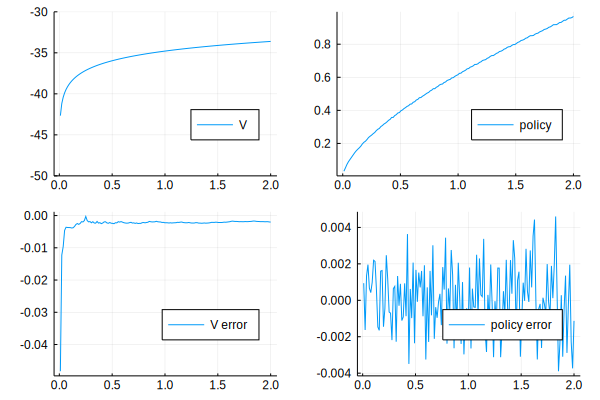

In [16]:
using Interpolations
using Optim
function bellman_operator2(grid,v0)
    
    v1  = zeros(n)     # next guess
    pol = zeros(n)     # consumption policy function

    Interp = interpolate((collect(grid),), v0, Gridded(Linear()) ) 
    Interp = extrapolate(Interp,Interpolations.Flat())

    # loop over current states
    # of current capital
    for (i,k) in enumerate(grid)

        objective(c) = - (log.(c) + beta * Interp(f(k) - c))
        # find max of ojbective between [0,k^alpha]
        res = optimize(objective, 1e-6, f(k))  # Optim.jl
        pol[i] = f(k) - res.minimizer   # k'
        v1[i] = -res.minimum
    end
    return (v1,pol)   # return both value and policy function
end

function VFI2()
    v_init = zeros(n)     # initial guess
    for iter in 1:N_iter
        v_next = bellman_operator2(kgrid,v_init)  # returns a tuple: (v1,pol)
        # check convergence
        if maximum(abs,v_init.-v_next[1]) < tol
            verrors = maximum(abs,v_next[1].-v_star(kgrid))
            perrors = maximum(abs,v_next[2].-k_star(kgrid))
            println("continuous VFI:")
            println("Found solution after $iter iterations")
            println("maximal value function error = $verrors")
            println("maximal policy function error = $perrors")
            return v_next
        elseif iter==N_iter
            warn("No solution found after $iter iterations")
            return v_next
        end
        v_init = v_next[1]  # update guess 
    end
    return nothing
end

function plotVFI2()
    v = VFI2()
    p = Any[]
    
    # value and policy functions
    push!(p,plot(kgrid,v[1],
            lab="V",
            ylim=(-50,-30),legend=:bottomright),
            plot(kgrid,v[2],
            lab="policy",legend=:bottomright))
    
    # errors of both
    push!(p,plot(kgrid,v[1].-v_star(kgrid),
        lab="V error",legend=:bottomright),
        plot(kgrid,v[2].-k_star(kgrid),
        lab="policy error",legend=:bottomright))

    plot(p...,layout=grid(2,2) )
    
end

plotVFI2()

## Policy Function Iteration

* This is similar to VFI but we now guess successive *policy* functions
* The idea is to choose a new policy $p^*$ in each iteration so as to satisfy an optimality condition. In our example, that would be the Euler Equation.
* We know that the solution to the above problem is a function $c^*(k)$ such that

$$ 
   c^*(k) = \arg \max_z u(z) + \beta V(f(k)-z) \text{  }\forall k\in[0,\infty]
$$

* We **don't** directly solve the maximiation problem outlined above, but it's first order condition:

$$
\begin{aligned}
u'(c^*(k_t)) & = \beta u'(c^*(k_{t+1})) f'(k_{t+1}) \\
             & = \beta u'[c^*(f(k_{t})-c^*(k_t))] f'(f(k_{t})-c^*(k_t)) 
\end{aligned}
$$

* In practice, we have to find the zeros of

$$
g(k_t) = u'(c^*(k_t)) - \beta u'[c^*(f(k_{t})-c^*(k_t))] f'(f(k_{t})-c^*(k_t)) 
$$

PFI:
Found solution after 39 iterations
max policy function error = 7.301895796647112e-5


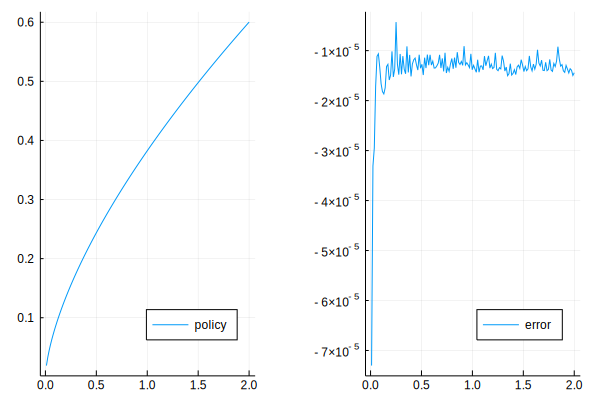

In [11]:
# Your turn!


using Roots
function policy_iter(grid,c0,u_prime,f_prime)
    
    c1  = zeros(length(grid))     # next guess
    pol_fun = extrapolate(interpolate((collect(grid),), c0, Gridded(Linear()) ) , Interpolations.Flat())
    
    
    # loop over current states
    # of current capital
    for (i,k) in enumerate(grid)
        objective(c) = u_prime(c) - beta * u_prime(pol_fun(f(k)-c)) * f_prime(f(k)-c)
        c1[i] = fzero(objective, 1e-10, f(k)-1e-10) 
    end
    return c1
end

uprime(x) = 1.0 ./ x
fprime(x) = alpha * x.^(alpha-1)

function PFI()
    c_init = kgrid
    for iter in 1:N_iter
        c_next = policy_iter(kgrid,c_init,uprime,fprime)  
        # check convergence
        if maximum(abs,c_init.-c_next) < tol
            perrors =  maximum(abs,c_next.-c_star(kgrid))
            println("PFI:")
            println("Found solution after $iter iterations")
            println("max policy function error = $perrors")
            return c_next
        elseif iter==N_iter
            warn("No solution found after $iter iterations")
            return c_next
        end
        c_init = c_next  # update guess 
    end
end
function plotPFI()
    v = PFI()
    plot(kgrid,[v v.-c_star(kgrid)],
            lab=["policy" "error"],
            legend=:bottomright,
            layout = 2)
end
plotPFI()
 

# Projection Methods

* Many applications require us to solve for an *unknown function*
    * ODEs, PDEs
    * Pricing functions in asset pricing models
    * Consumption/Investment policy functions
* Projection methods find approximations to those functions that set an error function close to zero.

## Example: Growth, again

* We stick to our working example from above.
* We encountered the Euler Equation $g$ for optimality.
* At the true consumption function $c^*$, $g(k) = 0$.
* We define the following function operator:


$$
\begin{aligned}
0 & = u'(c^*(k)) - \beta u'[c^*(f(k)-c^*(k))] f'(f(k)-c^*(k)) \\
 & \equiv (\mathcal{N(c^*)})(k)
\end{aligned}
$$

* The Equilibrium solves the operator equation
$$
0 = \mathcal{N}(c^*)
$$

### Projection Method example

1. create an approximation to $c^*$: 
    find 
    $$
    \bar{c} \equiv \sum_{i=0}^n a_i k^i
    $$
    
    which nearly solves 
    
    $$\mathcal{N}(c^*)=0
    $$
2. Compute Euler equation error function:
    $$ g(k;a) = u'(\bar{c}(k)) - \beta u'[\bar{c}(f(k)-\bar{c}(k))] f'(f(k)-\bar{c}(k))$$
3. Choose $a$ to make $g(k;a)$ small in some sense

What's *small in some sense*?

* Least-squares: minimize sum of squared errors
$$
\min_a \int g(k;a)^2 dk
$$
* Galerkin: zero out weighted averages of Euler errors
* Collocation: zero out Euler equation errors at grid $k\in\{k_1,\dots,k_n\}$:
$$
P_i(a) \equiv g(k_i;a) = 0, i=1,\dots,n
$$

### General Projection Method

1. Express solution in terms of unknown function
$$
 \mathcal{N}(h)=0
 $$
 where $h(x)$ is the equilibrium function at state $x$
1. Choose a space for appximation
1. Find $\bar{h}$ which nearly solves $$ \mathcal{N}(\bar{h})=0$$

### Projection method exercise

* suppose we want to find effective supply of an oligopolistic firm in cournot competition.
* We want to know $q = S(p)$, how much is supplied at each price $p$.
* This function is characterized as

$$
p + \frac{S(p)}{D'(p)} - MC(S(p)) = 0,\forall p>0
$$

* Take $D(p) = p^{-\eta}$ and $MC(q) = \alpha \sqrt{q} + q^2$.
* Our task is to solve for $S(p)$ in 

$$
p - \frac{S(p)p^{\eta+1}}{\eta} - \alpha \sqrt{S(p)} - S(p)^2 = 0,\forall p>0
$$

* No closed form solution. But collocation works!

#### TASK

1. solve for $S(p)$ by collocation
2. Plot residual function
3. Plot resulting $mS(p)$ together with market demand and $m=1,10,20$ for market size.

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3]
 * Zero: [0.248768, 0.0838916, -0.13965, 0.0447411, 0.00701804, -0.0135233, 0.00715223, -0.00229524, 0.000329096, 0.000224355, -0.000290968, 0.000210507, -0.000107876, 3.32945e-5, 4.04856e-6, -1.48411e-5, 1.28265e-5, -7.34842e-6, 2.74595e-6, -1.36709e-7, -8.28018e-7, 8.69542e-7, -5.79429e-7, 2.87391e-7, -1.02456e-7]
 * Inf-norm of residuals: 0.000000
 * Iterations: 9
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 8
 * Jacobian Calls (df/dx): 7


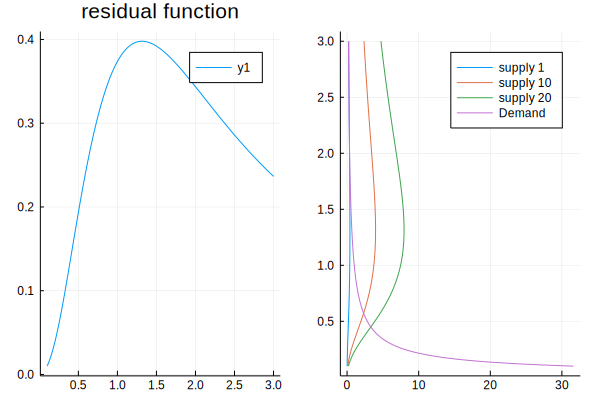

In [5]:
using CompEcon
using Plots
using NLsolve
function proj(n=25)

    alpha = 1.0
    eta   = 1.5
    a     = 0.1
    b     = 3.0
    basis = fundefn(:cheb,n,a,b)
    p     = funnode(basis)[1]   # collocation points

    c0 = ones(n)*0.3
    function resid!(c::Vector,result::Vector,p,basis,alpha,eta)
        # your turn!
        q = funeval(c,basis,p)[1]
        q2 = similar(q)
        for i in eachindex(q2)
            if q[i] < 0
                q2[i] = -20.0
            else
                q2[i] = sqrt(q[i])
            end
        end
        result[:] = p.+ q .*((-1/eta)*p.^(eta+1)) .- alpha*q2 .- q.^2
    end
    f_closure(r::Vector,x::Vector) = resid!(x,r,p,basis,alpha,eta)
    res = nlsolve(f_closure,c0)
    println(res)

    # plot residual function
     x = collect(range(a, stop = b, length = 501))
    y = similar(x)
    resid!(res.zero,y,x,basis,alpha,eta);
    y = funeval(res.zero,basis,x)[1]
    pl = Any[]
    push!(pl,plot(x,y,title="residual function"))
    
    # plot supply functions at levels 1,10,20
    
    # plot demand function
    y = funeval(res.zero,basis,x)[1]
    p2 = plot(y,x,label="supply 1")
    plot!(10*y,x,label="supply 10")
    plot!(20*y,x,label="supply 20")
    d = x.^(-eta)
    plot!(d,x,label="Demand")

    push!(pl,p2)
    
    plot(pl...,layout=2)
    
end
proj()

# Endogenous Grid Method (EGM)

* Fast, elegant and precise method to solve consumption/savings problems
* One continuous state variable
* One continuous control variable
    $$V(M_t) = \max_{0<c<M_t} u(c) + \beta E V_{t+1}(R (M_t - c) + y_{t+1})$$
* Here, $M_t$ is cash in hand, all available resources at the start of period $t$
    * For example, assets plus income.
* $A_t = M_t - c_t$ is end of period assets
* $y_{t+1}$ is stochastic next period income.
* $R$ is the gross return on savings, i.e. $R=1+r$.
* utility function can be of many forms, we only require twice differentiable and concave.

## EGM after [@carroll2006method]

* [@carroll2006method] <cite data-cite=carroll2006method></cite> introduced this method.
* The idea is as follows:
    * Instead of using non-linear root finding for optimal $c$ (see above)
    * fix a grid of possible end-of-period asset levels $A_t$
    * use structure of model to find implied beginning of period cash in hand.
    * We use euler equation and envelope condition to connect $M_{t+1}$ with $c_t$

### Recall Traditional Methods: VFI and Euler Equation 

* Just to be clear, let us repeat what we did in the beginning of this lecture, using the $M_t$ notation.
    $$
    \begin{aligned}
    V(M_t) &= \max_{0<c<M_t} u(c) + \beta E V_{t+1}(R (M_t - c) + y_{t+1}) \\
    M_{t+1} &= R (M_t - c) + y_{t+1} 
    \end{aligned}
    $$

### VFI

1. Define a grid over $M_t$.
2. In the final period, compute
    $$V_T(M_T) = \max_{0<c<M_t} u(c)$$
3. In all preceding periods $t$, do
    $$V_t(M_t) =  \max_{0<c_t<M_t} u(c_t) + \beta E V_{t+1}(R (M_t - c_t) + y_{t+1})$$
4. where optimal consumption is
    $$c_t^*(M_t) = \arg \max_{0<c_t<M_t} u(c_t) + \beta E V_{t+1}(R (M_t - c_t) + y_{t+1})$$



### Euler Equation

* The first order condition of the Bellman Equation is
    $$ 
    \begin{aligned}
    \frac{\partial V_t}{\partial c_t} & = 0 \\
    u'(c_t) & = \beta E \left[\frac{\partial V_{t+1} (M_{t+1}) }{\partial M_{t+1}} \right] \quad (FOC)
    \end{aligned}
    $$
* By the Envelope Theorem, we have that
    $$ 
    \begin{aligned}
    \frac{\partial V_t}{\partial M_t} & = \beta E \left[\frac{\partial V_{t+1} (M_{t+1}) }{\partial M_{t+1}} \right] \\
    \text{by FOC} &  \\
    \frac{\partial V_t}{\partial M_t} & = u'(c_t) \\
    \text{true in every period:} & \\
    \frac{\partial V_{t+1}}{\partial M_{t+1}} & = u'(c_{t+1}) 
    \end{aligned}
    $$
* Summing up, we get the Euler Equation:
    $$ u'(c_t) = \beta E \left[u'(c_{t+1}) R \right] $$

### Euler Equation Algorithm

1. Fix grid over $M_t$
1. In the final period, compute
    $$c_T^*(M_T) = \arg\max_{0<cT<M_t} u(c_T)$$
1. With optimal $c_{t+1}^*(M_{t+1})$ in hand, backward recurse to find $c_t$ from
    $$u'(c_t) = \beta E \left[u'(c_{t+1}^*(R (M_t - c_t) + y_{t+1}) ) R \right]$$
1. Notice that if $M_t$ is small, the euler equation does not hold.
    * In fact, the euler equation would prescribe to *borrow*, i.e. set $M_t <0$. This is ruled out.
    * So, one needs to tweak this algorithm to check for this possibility
1. Homework.



## The EGM Algorithm

Starts in period $T$ with $c_T^* = M_T$. For all preceding periods:

1. Fix a grid of *end-of-period* assets $A_t$
1. Compute all possible next period cash-in-hand holdings $M_{t+1}$
    $$ M_{t+1} = R * A_t + y_{t+1} $$
    * for example, if there are $n$ values in $A_t$ and $m$ values for $y_{t+1}$, we have $dim(M_{t+1}) = (n,m)$
1. Given that we know optimal policy in $t+1$, use it to get consumption at each $M_{t+1}$
    $$ c_{t+1}^* (M_{t+1}) $$
1. Invert the Euler Equation to get current consumption compliant with an expected level of cash-on-hand, given $A_t$
    $$ c_{t} = (u')^{-1} \left( \beta E \left[u'(c_{t+1}^*(M_{t+1}) ) R |A_t \right]  \right) $$
1. Current period *endogenous* cash on hand just obeys the accounting relation
    $$ M_t = c_t + A_t $$



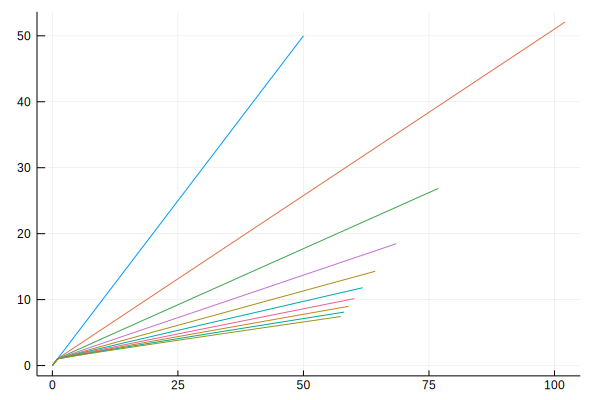

In [2]:
# minimal EGM implementation, go here: https://github.com/floswald/DCEGM.jl/blob/master/src/dc_algo.jl#L4
# try out: 
# ] dev https://github.com/floswald/DCEGM.jl
using DCEGM
DCEGM.minimal_EGM(dplot = true);



## Discrete Choice EGM

* This is a method developed by Fedor Iskhakov, Thomas Jorgensen, John Rust and Bertel Schjerning.
* Reference: [@iskhakovRust2014] <cite data-cite=iskhakovRust2014></cite>
* Suppose we have several discrete choices (like "work/retire"), combined with a continuous choice in each case (like "how much to consume given work/retire").
* Let $d=0$ mean to retire.
* Write the problem of a worker as

$$
\begin{aligned}
V_t(M_t) & = \max \left[ v_t(M_t|d_t=0), v_t(M_t|d_t=1) \right] \\
 &  \text{with}\\
v_t(M_t|d_t=0) & = \max_{0<c_t<M_t} u(c_t) + \beta E W_{t+1}(R (M_t - c_t)) \\
v_t(M_t|d_t=1) & = \max_{0<c_t<M_t} u(c_t) -1 + \beta E V_{t+1}(R (M_t - c_t) + y_{t+1}) 
\end{aligned}
$$

* The problem of a retiree is

$$
W_t(M_t) = \max_{0<c_t<M_t} u(c_t) + \beta E W_{t+1}(R (M_t - c_t))
$$
    
* Our task is to compute the optimal consumption functions $c_t^*(M_t|d_t=0)$, $c_t^*(M_t|d_t=1)$

### Problems with Discrete-Continuous Choice

* Even if all conditional value functions $v$ are concave, the *envelope* over them, $V$, is in general not.
* [@clausenenvelope] <cite data-cite=clausenenvelope></cite>show that there will be a kink point $\bar{M}$ such that 
    $$ v_t(\bar{M}|d_t=0) = v_t(\bar{M}|d_t=1) $$
    * We call any such point a **primary kink** (because it refers to a discrete choice in the **current period**)
* $V$ is not differentiable at $\bar{M}$.
* However, it can be shown that both left and right derivatives exist, with
    $$ V^-(\bar{M}) < V^+(\bar{M}) $$
* Given that the value of the derivative changes discretely at $\bar{M_t}$, the value function in $t-1$ will exhibit a discontinuity as well:
    * $v_{t-1}$ depends on $V_t$.
    * Tracing out the optimal choice of $c_{t-1}$ implies next period cash on hand $M_t$, and as that hits $\bar{M_t}$, the derivative jumps.
    * The derivative of the value function determines optimal behaviour via the Euler Equation.
    * We call a discontinuity in $v_{t-1}$ arising from a kink in $V_t$ a **secondary kink**.
* The kinks propagate backwards. 



* [@iskhakovRust2014] <cite data-cite=iskhakovRust2014></cite> provide an analytic example where one can compute the actual number of kinks in period 1 of T.
* Figure 1 in [@clausenenvelope]:

<img src="../assets/figs/clausen-struub.png" width="1200" height="500"/>

![[@iskhakovRust2014] figure 1](../assets/figs/fedor-1.png)




### Kinks

* Refer back to the work/retirement model from before.
* 6 period implementation of the DC-EGM method:

![github/floswald](../assets/figs/Dchoice_condV.png)

* [Iskhakov @ cemmap 2015: Value functions in T-1](http://www.cemmap.ac.uk/event/id/1213)
<img src="../assets/figs/fedor-3.png" width="900" height="500"/>


* [Iskhakov @ cemmap 2015: Value functions in T-2](http://www.cemmap.ac.uk/event/id/1213)
<img src="../assets/figs/fedor-4.png" width="900" height="500"/>

* [Iskhakov @ cemmap 2015: Consumption function in T-2](http://www.cemmap.ac.uk/event/id/1213)
<img src="../assets/figs/fedor-5.png" width="900" height="500"/>

* Optimal consumption in 6 period model:
![github/floswald](../assets/figs/Dchoice_envC.png)

### The Problem with Kinks

* Relying on fast methods that rely on first order conditions (like euler equation) will fail.
* There are multiple zeros in the Euler Equation, and a standard Euler Equation approach is not guaranteed to find the right one.
* picture from Fedor Iskhakov's master class at [cemmap 2015](http://www.cemmap.ac.uk/event/id/1213):

<img src="../assets/figs/fedor-2-cropped.png" width="1000" height="500"/>




### DC-EGM Algorithm

1. Do the EGM step for each discrete choice $d$
1. Compute $d$-specific consumption and value functions
1. compare $d$-specific value functions to find optimal switch points
1. Build envelope over $d$-specific consumption functions with knowledge of which optimal $d$ applies where.

### But EGM relies on the Euler Equation?!

* Yes.
* An important result in [@clausenenvelope] is that the Euler Equation is still the necessary condition for optimal consumption
    * Intuition: marginal utility differs greatly at $\epsilon+\bar{M}$. 
    * No economic agent would ever locate **at** $\bar{M}$.
* This is different from saying that a proceedure that tries to find the zeros of the Euler Equation would still work.
    * this will pick the wrong solution some times.
* EGM finds **all** solutions. 
    * There is a proceedure to discard the "wrong ones". Proof in [@iskhakovRust2014]






### Adding Shocks

* This problem is hard to solve with standard methods.
* It is hard, because the only reliable method is VFI, and this is not feasible in large problems.
* Adding shocks to non-smooth problems is a widely used remedy.
    * think of "convexifying" in game theoretic models
    * (Add a lottery)
    * Also used a lot in macro
* Adding shocks does indeed help in the current model.
    * We add idiosyncratic taste shocks: Type 1 EV.
    * Income uncertainty: 
    * In general, the more shocks, the more smoothing.
* The problem becomes

$$
\begin{aligned}
V_t(M_t) & = \max \left[ v_t(M_t|d_t=0) + \sigma_\epsilon \epsilon_t(0), v_t(M_t|d_t=1) + \sigma_\epsilon \epsilon_t(1)\right]  \\
v_t(M_t|d_t=1) & = \max_{0<c_t<M_t} \log(c_t) -1 + \beta \int E V_{t+1}(R (M_t - c_t) + y\eta_{t+1})f(d\eta_{t+1}) 
\end{aligned}
$$

where the value for retirees stays the same.




### Adding Shocks


![[@iskhakovRust2014] figure 2](../assets/figs/fedor-7.png)

![[@iskhakovRust2014] figure 4](../assets/figs/fedor-6.png)


![[@iskhakovRust2014] figure 4](../assets/figs/fedor-8.png)



### Full DC-EGM

* Needs to discard *false* solutions. 
* Criterion:    
    * grid in $A_t$ is **increasing**
    * Assuming concave utility function, the function
        $$ A(M|d) = M - c(M|d) $$
        is **monotone non-decreasing**
    * This means that, if you go through $A_i$, and find that
        $$ M_t(A^j) < M_t(A^{j-1}) $$
        you know you entered a non-concave region
* The Algorithm goes through the upper envelope and *prunes* the *inferior* points $M$ from the endogenous grids.
* Precise details of Algorithm in paper.
* Julia implementation on [floswald/ConsProb.jl](https://github.com/floswald/ConsProb.jl)

